* logit이란 : https://hwiyong.tistory.com/335
* tensorflow에서 from_logit : https://utto.tistory.com/8

# mnist classification networks

In [47]:
import tensorflow as tf
import tensorflow_datasets as tfds
print(tf.config.list_physical_devices('GPU'))
# mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"]) # Multi GPU 시용시

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [57]:
BATCH_SIZE = 128

mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = (train_images/127.5) - 1
test_images = (test_images/127.5) - 1

train_images = tf.expand_dims(train_images, -1)
test_images = tf.expand_dims(test_images, -1)

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.shuffle(1000).batch(BATCH_SIZE).cache().prefetch(buffer_size=AUTOTUNE)

In [58]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(128, 28, 28, 1)
(128,)


2023-05-22 14:49:17.326138: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [67]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='leaky_relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='leaky_relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='leaky_relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='leaky_relu'),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [68]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [69]:
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=3,restore_best_weights=True)
model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=50,
    callbacks=[es],
)

Epoch 1/50
469/469 [==============================] - 3s 6ms/step - loss: 0.3707 - accuracy: 0.8842 - val_loss: 0.1241 - val_accuracy: 0.9615
Epoch 2/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1033 - accuracy: 0.9689 - val_loss: 0.0841 - val_accuracy: 0.9752
Epoch 3/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0757 - accuracy: 0.9775 - val_loss: 0.0774 - val_accuracy: 0.9776
Epoch 4/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0605 - accuracy: 0.9818 - val_loss: 0.0749 - val_accuracy: 0.9786
Epoch 5/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0507 - accuracy: 0.9850 - val_loss: 0.0723 - val_accuracy: 0.9801
Epoch 6/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0440 - accuracy: 0.9872 - val_loss: 0.0703 - val_accuracy: 0.9812
Epoch 7/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0386 - accuracy: 0.9887 - val_loss: 0.0668 - val_accuracy: 0.9825
Epoch 

# mnist GAN

In [10]:
import warnings
warnings.filterwarnings(action='ignore')

2023-05-22 14:04:24.241050: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


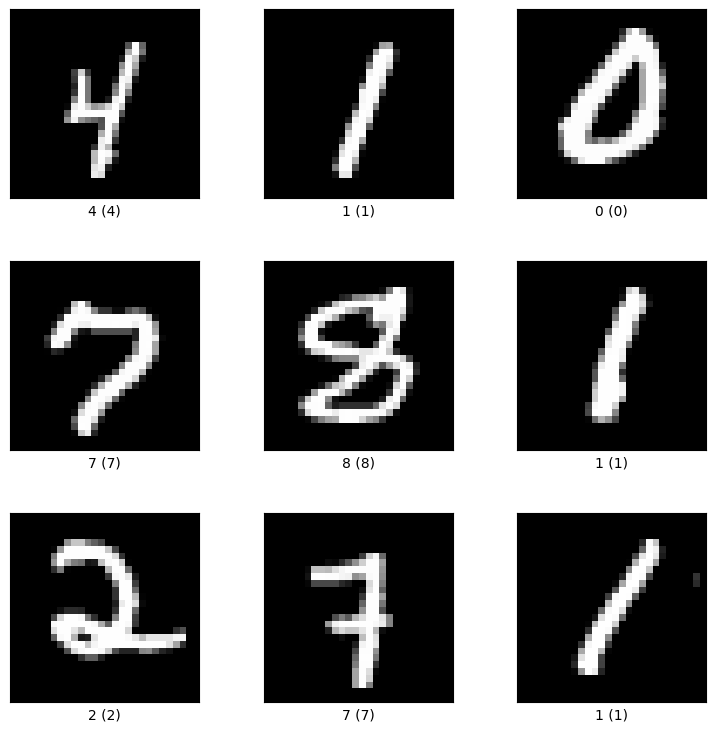

In [11]:
import tensorflow_datasets as tfds

mnist, info =  tfds.load("mnist", split="train", with_info=True)

# image와 레이블을 출력
fig = tfds.show_examples(mnist, info)

In [12]:
import tensorflow as tf

BATCH_SIZE = 128

def gan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def cgan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    
    # label을 웟-핫으로
    label = tf.one_hot(data["label"], 10)
    return image, label

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)

Label : tf.Tensor([0. 0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
Image Min/Max : -1.0 1.0


2023-05-22 14:04:32.187368: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


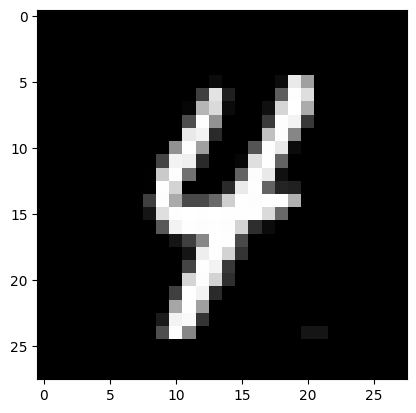

In [13]:
import matplotlib.pyplot as plt

for i,j in cgan_datasets : break

# 이미지 i와 라벨 j가 일치하는지 확인해 봅니다.     
print("Label :", j[0])
print("Image Min/Max :", i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0,...,0], plt.cm.gray)

In [14]:
from tensorflow.keras import layers, Input, Model

class GeneratorGAN(Model):
    def __init__(self):
        super(GeneratorGAN, self).__init__()
        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(256, activation='relu')
        self.dense_3 = layers.Dense(512, activation='relu')
        self.dense_4 = layers.Dense(28*28*1, activation='tanh')

        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise):
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out)

In [35]:
from tensorflow.keras import optimizers, losses

bce = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    # fake_output.shape는 (batch, digit)
    fake_gen_loss = bce(tf.ones_like(fake_output), fake_output)
    return fake_gen_loss

def discriminator_loss(real_output, fake_output):
    real_disc_loss = bce(tf.ones_like(real_output), real_output) # real을 real로 파악했는가?
    fake_disc_loss = bce(tf.zeros_like(fake_output), fake_output) # fake를 fake로 파악했는가?
    return 0.5* real_disc_loss + 0.5 * fake_disc_loss

In [38]:
gan_generator = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()

@tf.function()
def gan_step(real_images):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        # Generator를 이용해 가짜 이미지 생성
        fake_images = gan_generator(noise)
        # Discriminator를 이용해 진짜 및 가짜이미지를 각각 판별
        real_out = gan_discriminator(real_images)
        fake_out = gan_discriminator(fake_images)
        # 각 손실(loss)을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    # gradient 계산
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
    return gene_loss, disc_loss

In [39]:
EPOCHS = 100
for epoch in range(EPOCHS):
    for i, images in enumerate(gan_datasets):
        gene_loss, disc_loss = gan_step(images)

    if (epoch) % 10 == 0:
        print(f"[{epoch}/{EPOCHS} EPOCHS] G:{gene_loss}, D:{disc_loss}")

[0/100 EPOCHS] G:2.655237913131714, D:0.3424992859363556
[10/100 EPOCHS] G:6.163552761077881, D:0.024144798517227173
[20/100 EPOCHS] G:4.606828689575195, D:0.02272977866232395
[30/100 EPOCHS] G:9.295183181762695, D:0.00026752075063996017
[40/100 EPOCHS] G:4.489532947540283, D:0.046108707785606384
[50/100 EPOCHS] G:6.881746768951416, D:0.09965143352746964
[60/100 EPOCHS] G:4.398305416107178, D:0.14173327386379242
[70/100 EPOCHS] G:2.8211934566497803, D:0.12134382128715515
[80/100 EPOCHS] G:2.5756444931030273, D:0.16082890331745148
[90/100 EPOCHS] G:2.203597068786621, D:0.34770622849464417


In [43]:
EPOCHS = 200
for epoch in range(100,EPOCHS):
    for i, images in enumerate(gan_datasets):
        gene_loss, disc_loss = gan_step(images)

    if (epoch) % 10 == 0:
        print(f"[{epoch}/{EPOCHS} EPOCHS] G:{gene_loss}, D:{disc_loss}")

[100/200 EPOCHS] G:2.457141876220703, D:0.28444212675094604
[110/200 EPOCHS] G:2.140305995941162, D:0.36696863174438477
[120/200 EPOCHS] G:2.0283899307250977, D:0.28632214665412903
[130/200 EPOCHS] G:1.8464826345443726, D:0.3297426104545593
[140/200 EPOCHS] G:1.9465252161026, D:0.30695319175720215
[150/200 EPOCHS] G:1.8521838188171387, D:0.2685491442680359
[160/200 EPOCHS] G:1.8339122533798218, D:0.3296242952346802
[170/200 EPOCHS] G:1.6027512550354004, D:0.39575958251953125
[180/200 EPOCHS] G:2.08798885345459, D:0.33636632561683655
[190/200 EPOCHS] G:1.7654134035110474, D:0.39342090487480164


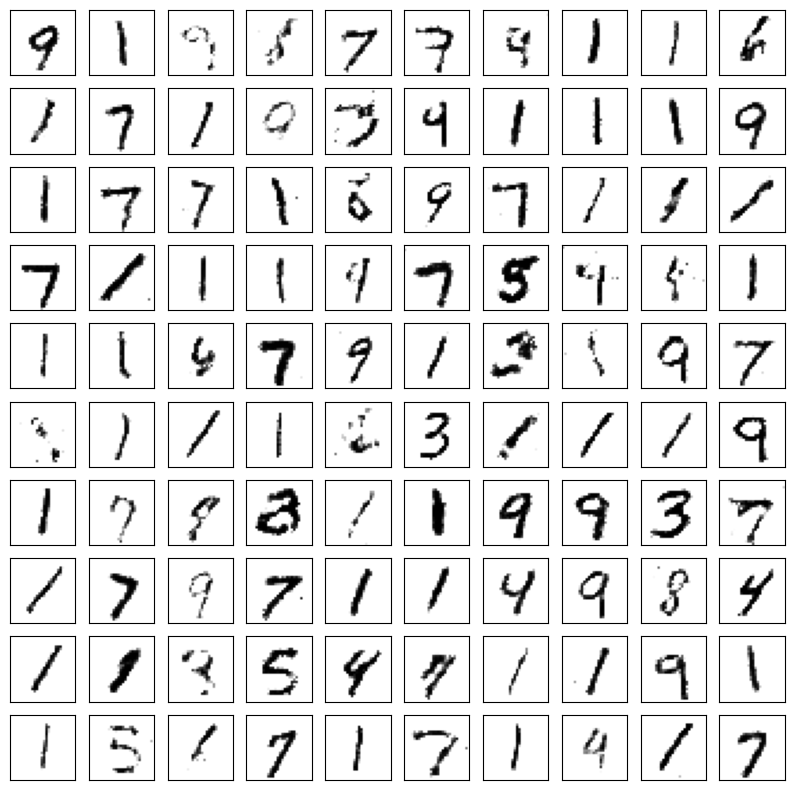

In [45]:
noise = tf.random.normal([100, 100],seed=10)
fake_images = gan_generator(noise)

display_sample_img(fake_images, (10,10))

In [87]:
import numpy as np

noise = tf.random.normal([10, 100])

output = gan_generator(noise)
print(output.shape)
output = np.squeeze(output.numpy())
print(output.shape)

(10, 28, 28, 1)
(10, 28, 28)


In [81]:
from collections import Counter
noise = tf.random.normal([10000, 100])
fake_images = gan_generator(noise)

result = Counter(np.argmax(model.predict(fake_images),axis=1))
[(l,k) for k,l in sorted([(j,i) for i,j in result.items()], reverse=True)]

313/313 [==============================] - 1s 3ms/step


[(1, 4566),
 (7, 2276),
 (9, 1312),
 (3, 533),
 (4, 423),
 (8, 360),
 (2, 191),
 (5, 186),
 (6, 117),
 (0, 36)]

* 많은 경우에서 1이 대부분 보이는 것을 알 수 있다.
* 개수의 차이가 많이 난다.

# mnist CGAN

In [82]:
class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        self.dense_z = layers.Dense(256, activation='relu')
        self.dense_y = layers.Dense(256, activation='relu')
        self.combined_dense = layers.Dense(512, activation='relu')
        self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise, label):
        noise = self.dense_z(noise)
        label = self.dense_y(label)
        out = self.combined_dense(tf.concat([noise, label], axis=-1))
        out = self.final_dense(out)
        return self.reshape(out)

In [83]:
class DiscriminatorGAN(Model):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.blocks = []
        for f in [512, 256, 128, 1]:
            self.blocks.append(
                layers.Dense(f, activation=None if f==1 else "relu")
            )
        
    def call(self, x):
        x = self.flatten(x)
        for block in self.blocks:
            x = block(x)
        return x

In [84]:
class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        self.dense = layers.Dense(units*pieces, activation="relu")
        self.dropout = layers.Dropout(.5)    
        self.reshape = layers.Reshape((-1, pieces, units))
    
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=2)

In [85]:
class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.image_block = Maxout(240, 5)
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        
        self.dense = layers.Dense(1, activation=None)
    
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image)
        label = self.label_block(label)
        x = layers.Concatenate()([image, label])
        x = self.combine_block(x)
        return self.dense(x)

In [89]:
cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    
    # 배치 개수 만큼, noise_dim = 100
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        # cgan(노이즈, 라벨)로 fake 이미지 생성
        fake_images = cgan_generator(noise, labels)
        
        # cdisc(real 이미지, 라벨) => real_digit
        # cdisc(fake 이미지, 라벨) => fake_digit
        real_out = cgan_discriminator(real_images, labels)
        fake_out = cgan_discriminator(fake_images, labels)
        
        # fake_digit
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    return gene_loss, disc_loss


EPOCHS = 100
for epoch in range(EPOCHS):
    
    for i, (images, labels) in enumerate(cgan_datasets):
        gene_loss, disc_loss = cgan_step(images, labels)
    
    if (epoch) % 10 == 0:
        print(f"[{epoch}/{EPOCHS} EPOCHS] G:{gene_loss}, D:{disc_loss}")

[0/100 EPOCHS] G:5.309499263763428, D:0.007554084062576294
[10/100 EPOCHS] G:5.515949726104736, D:0.016267288476228714
[20/100 EPOCHS] G:7.2701640129089355, D:0.022578729316592216
[30/100 EPOCHS] G:6.266505718231201, D:0.0200207456946373
[40/100 EPOCHS] G:5.247509479522705, D:0.1721065789461136
[50/100 EPOCHS] G:3.0960094928741455, D:0.2244686335325241
[60/100 EPOCHS] G:4.8119378089904785, D:0.23226161301136017
[70/100 EPOCHS] G:3.470125198364258, D:0.22719192504882812
[80/100 EPOCHS] G:3.2193870544433594, D:0.2824583351612091
[90/100 EPOCHS] G:2.804151773452759, D:0.3114108443260193


In [93]:
EPOCHS = 200
for epoch in range(100,EPOCHS):
    
    for i, (images, labels) in enumerate(cgan_datasets):
        gene_loss, disc_loss = cgan_step(images, labels)
    
    if (epoch) % 10 == 0:
        print(f"[{epoch}/{EPOCHS} EPOCHS] G:{gene_loss}, D:{disc_loss}")

[100/200 EPOCHS] G:2.0724167823791504, D:0.36747312545776367
[110/200 EPOCHS] G:2.1045711040496826, D:0.3615994453430176
[120/200 EPOCHS] G:2.6495518684387207, D:0.4200708568096161
[130/200 EPOCHS] G:1.657086730003357, D:0.382604718208313
[140/200 EPOCHS] G:2.2626235485076904, D:0.44879212975502014
[150/200 EPOCHS] G:1.8969502449035645, D:0.4420814514160156
[160/200 EPOCHS] G:1.6762176752090454, D:0.41435152292251587
[170/200 EPOCHS] G:2.676588296890259, D:0.30421945452690125
[180/200 EPOCHS] G:2.6217966079711914, D:0.2596643567085266
[190/200 EPOCHS] G:3.9875259399414062, D:0.356680303812027


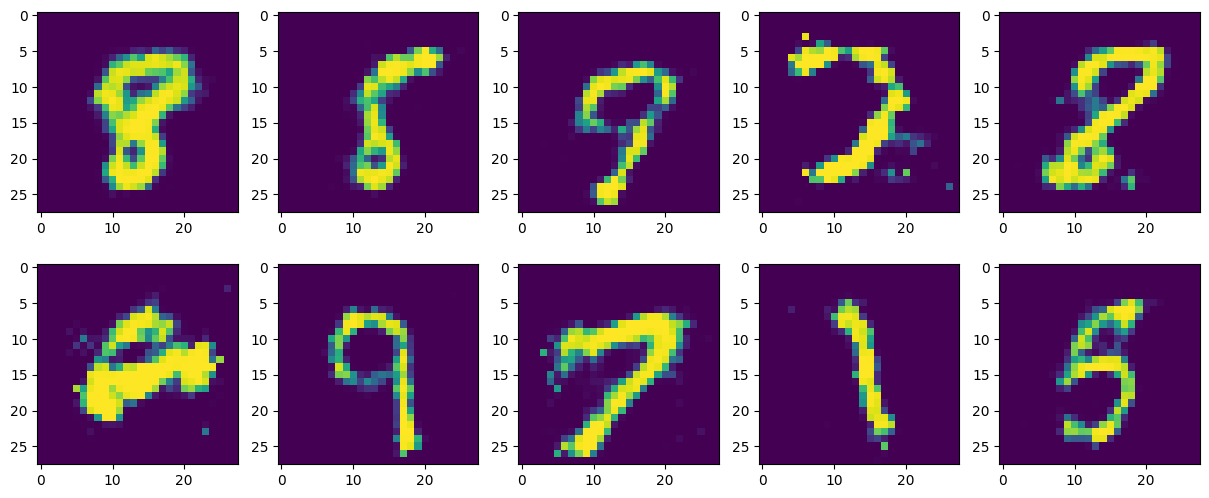

In [97]:
number = 9  # TODO : 생성할 숫자를 입력해 주세요!!

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

output = cgan_generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

CGAN을 사용했음에도 불구하고 아직 특정 class만 생성하는것은 힘든 것으로 보입니다.